# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры.
Дополнительно будем измерять *AUC-ROC*, сравнивайте её значение с *F1*-мерой.


## Подготовка данных

### Для начала импортируем все необходимые библиотеки

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt

### Откроем и изучим датасет

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Есть пропуски в информации о количестве лет, с уходом клиента они вряд-ли связаны, учитывая, что первый же клиент из таблицы ушёл, а вот значение не пропущены. Возможно пропуски обозначают то, что клиент является клиентом банка меньше одного года

In [6]:
data['Tenure'].unique()
#проверим теорию о пропусках

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [7]:
data['Tenure'] = data['Tenure'].fillna('')

Действительно нули есть. В таком случае лучше будет оставить эти пропуски. Однако нужно избавиться от значения NaN, поскольку модели его не принимают

### Теперь подготовим таблицу с помощью прямого кодирования

In [8]:
data_ohe = pd.get_dummies(data, drop_first=True)

Используется именно прямое кодирование, поскольку будет проверяться много различных моделей

### Далее разделим данные на обучающую, валидационную и тестовую выборки и масштабируем их

Соотнешение предлагаю выбрать 60:20:20

In [9]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

In [10]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.20, random_state=9091)
features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=0.25, random_state=9091)

In [11]:
scaler = StandardScaler()
scaler.fit(features_train) 
features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid) 
features_test_scaled = scaler.transform(features_test) 

In [12]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 2954)
(2000, 2954)
(2000, 2954)


Выборки подготовлены масштабированны можно начинать обучение моделей

## Исследование задачи

Перед нами стоит задача классификации, попробуем разные модели. Пока что без учёта дисбаланса, но для начала проверим, насколько сильный дисбаланс в целом

In [13]:
print('Распределение клиентов')
print(target_train.value_counts())

Распределение клиентов
0    4798
1    1202
Name: Exited, dtype: int64


распределение клиентов в процентах


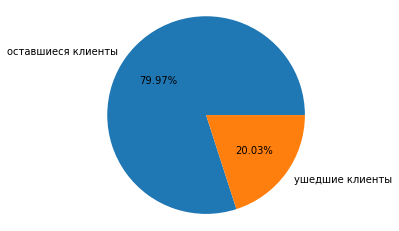

In [14]:
print('распределение клиентов в процентах')
fig1, ax1 = plt.subplots()
ax1.pie(target_train.value_counts(), 
        labels=['оставшиеся клиенты', 'ушедшие клиенты'], 
        autopct='%1.2f%%')
ax1.axis('equal')
plt.show()

в обучающей выборке ушло в 4 раза меньше клиентов, чем осталось, кажется присутствует дисбаланс.

### Для начала проверим качество дерева решений

In [15]:
%%time
best_model = None
best_result = 0
best_auc_roc = 0
for depth in range(1, 51):
    model = DecisionTreeClassifier(random_state=9091, max_depth=depth) 
    model.fit(features_train_scaled, target_train)
    predicted_valid = model.predict(features_valid_scaled)
    result = f1_score(target_valid, predicted_valid)
    probabilities_valid = model.predict_proba(features_valid_scaled)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_auc_roc = auc_roc
print('лучший показатель F1:', best_result)
print('лучшая модель:', best_model)
print('лучший показатель AUC-ROC:', best_auc_roc)
print()
print('длительность расчётов:')

лучший показатель F1: 0.5603328710124826
лучшая модель: DecisionTreeClassifier(max_depth=9, random_state=9091)
лучший показатель AUC-ROC: 0.7663342400868575

длительность расчётов:
CPU times: user 24.6 s, sys: 977 ms, total: 25.6 s
Wall time: 27.8 s


не самые лучшие показатели, до необходимых нам значений ещё далеко...

### Теперь попробуем случайный лес

In [16]:
%%time
best_model = None
best_result = 0
best_auc_roc = 0
for est in range(1, 21):
    for depth in range(1, 21):
        model = RandomForestClassifier(random_state=9091, n_estimators=est, max_depth=depth)
        model.fit(features_train_scaled, target_train)
        predicted_valid = model.predict(features_valid_scaled)
        result = f1_score(target_valid, predicted_valid)
        probabilities_valid = model.predict_proba(features_valid_scaled)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_auc_roc = auc_roc
print('лучший показатель F1:', best_result)
print('лучшая модель:', best_model)
print('лучший показатель AUC-ROC:', best_auc_roc)
print()
print('длительность расчётов:')                

лучший показатель F1: 0.1787941787941788
лучшая модель: RandomForestClassifier(max_depth=17, n_estimators=2, random_state=9091)
лучший показатель AUC-ROC: 0.7254878274304871

длительность расчётов:
CPU times: user 1min 5s, sys: 7.9 s, total: 1min 13s
Wall time: 1min 13s


Со случайным лесом получились очень низкие показатели, возможно на это влияет дисбаланс, а может такая модель попросту неподходит для нашей задачи

### Попробуем Extra Trees Classifier

In [17]:
%%time
best_model = None
best_result = 0
best_auc_roc = 0
for depth in range(1, 51):
    model = ExtraTreesClassifier(random_state=9091, max_depth=depth) 
    model.fit(features_train_scaled, target_train)
    predicted_valid = model.predict(features_valid_scaled)
    result = f1_score(target_valid, predicted_valid)
    probabilities_valid = model.predict_proba(features_valid_scaled)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_auc_roc = auc_roc
print('лучший показатель F1:', best_result)
print('лучшая модель:', best_model)
print('лучший показатель AUC-ROC:', best_auc_roc)
print()
print('длительность расчётов:')

лучший показатель F1: 0.08108108108108109
лучшая модель: ExtraTreesClassifier(max_depth=46, random_state=9091)
лучший показатель AUC-ROC: 0.783523035715351

длительность расчётов:
CPU times: user 2min 27s, sys: 1.21 s, total: 2min 28s
Wall time: 2min 29s


Результаты пока что становятся только хуже, при том как f1, так и значение auc-roc

### Немного поэксперементируем и попробуем многоуровневый классификатор

In [18]:
%%time
model = MLPClassifier(random_state=9091) 
model.fit(features_train_scaled, target_train)
predicted_valid = model.predict(features_valid_scaled)
result = f1_score(target_valid, predicted_valid)
probabilities_valid = model.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(result)
print(auc_roc)

0.20105820105820105
0.6038665282674445
CPU times: user 5min 38s, sys: 5min 34s, total: 11min 13s
Wall time: 11min 14s


Результаты не очень хорошие

### Посмотрим как покажет себя ada boost

In [19]:
%%time
best_model = None
best_result = 0
best_auc_roc = 0
for est in range(1, 51):
    model = AdaBoostClassifier(random_state=9091, n_estimators=est)
    model.fit(features_train_scaled, target_train)
    predicted_valid = model.predict(features_valid_scaled)
    result = f1_score(target_valid, predicted_valid)
    probabilities_valid = model.predict_proba(features_valid_scaled)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_auc_roc = auc_roc
print('лучший показатель F1:', best_result)
print('лучшая модель:', best_model)
print('лучший показатель AUC-ROC:', best_auc_roc)
print()
print('длительность расчётов:')

лучший показатель F1: 0.5521292217327459
лучшая модель: AdaBoostClassifier(n_estimators=26, random_state=9091)
лучший показатель AUC-ROC: 0.8262836229575675

длительность расчётов:
CPU times: user 2min 48s, sys: 49.2 s, total: 3min 37s
Wall time: 3min 40s


Очень близко к дереву решений, однако результат всё таки хуже

### Возможно градиентный классификатор сможет превзойти наше лучшее дерево

In [20]:
%%time
best_model = None
best_result = 0
best_auc_roc = 0
for est in range(1, 21):
    for depth in range(1, 11):
        model = GradientBoostingClassifier(random_state=9091, n_estimators=est, max_depth=depth)
        model.fit(features_train_scaled, target_train)
        predicted_valid = model.predict(features_valid_scaled)
        result = f1_score(target_valid, predicted_valid)
        probabilities_valid = model.predict_proba(features_valid_scaled)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_auc_roc = auc_roc
print('лучший показатель F1:', best_result)
print('лучшая модель:', best_model)
print('лучший показатель AUC-ROC:', best_auc_roc)
print()
print('длительность расчётов:')    

лучший показатель F1: 0.5480314960629922
лучшая модель: GradientBoostingClassifier(max_depth=7, n_estimators=20, random_state=9091)
лучший показатель AUC-ROC: 0.8381720863086183

длительность расчётов:
CPU times: user 7min 20s, sys: 3.81 s, total: 7min 23s
Wall time: 7min 24s


К сожалению не смог, да и времени ушло давольно много

### Интересно как себя покажет линейный классификатор

In [21]:
%%time
best_model = None
best_result = 0
best_auc_roc = 0
for it in range(1, 11):
    model = RidgeClassifier(random_state=9091, max_iter=it)
    model.fit(features_train_scaled, target_train)
    predicted_valid = model.predict(features_valid_scaled)
    result = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_auc_roc = auc_roc
print('лучший показатель F1:', best_result)
print('лучшая модель:', best_model)
print('лучший показатель AUC-ROC:', best_auc_roc)
print()
print('длительность расчётов:')

лучший показатель F1: 0.21512605042016808
лучшая модель: RidgeClassifier(max_iter=1, random_state=9091)
лучший показатель AUC-ROC: 0.5417628600915104

длительность расчётов:
CPU times: user 36.4 s, sys: 19.8 s, total: 56.2 s
Wall time: 56.3 s


Линейный классификатор так же показал себя не очень хорошо. 

После масштабирования данных качество всех моделей улучшилось, посмотрим что будет после победы дисбаланса

## Борьба с дисбалансом

теперь постараемся справиться с дисбалансом в выборке путём увеличения количества ушедших клиентов. Сделаем их равными по количеству, для этого нужно увеличить число ушедших клиентов в 4 раза.

### Для начала создадим функцию, которая будет сортировать нашу выборку

In [22]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_train_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_train_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_train_upsampled, target_train_upsampled = shuffle(
        features_train_upsampled, target_train_upsampled, random_state=9091)
    return features_train_upsampled, target_train_upsampled
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

In [23]:
features_train_upsampled = scaler.transform(features_train_upsampled)

### Теперь можем попробовать те же модели, но с учётом дисбаланса, начнём так же с решающего дерева

In [24]:
%%time
best_model = None
best_result = 0
best_auc_roc = 0
for depth in range(1, 51):
    model = DecisionTreeClassifier(random_state=9091, max_depth=depth) 
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted_valid = model.predict(features_valid_scaled)
    result = f1_score(target_valid, predicted_valid)
    probabilities_valid = model.predict_proba(features_valid_scaled)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_auc_roc = auc_roc
print('лучший показатель F1:', best_result)
print('лучшая модель:', best_model)
print('лучший показатель AUC-ROC:', best_auc_roc)
print()
print('длительность расчётов:')

лучший показатель F1: 0.5691854759568203
лучшая модель: DecisionTreeClassifier(max_depth=6, random_state=9091)
лучший показатель AUC-ROC: 0.8202622128365279

длительность расчётов:
CPU times: user 30.5 s, sys: 1.5 s, total: 32 s
Wall time: 32.1 s


Результат стал лучше, но не сильно

### Случайный лес

In [25]:
%%time
best_model = None
best_result = 0
best_auc_roc = 0
for est in range(1, 41):
    for depth in range(1, 21):
        model = RandomForestClassifier(random_state=9091, n_estimators=est, max_depth=depth)
        model.fit(features_train_upsampled, target_train_upsampled)
        predicted_valid = model.predict(features_valid_scaled)
        result = f1_score(target_valid, predicted_valid)
        probabilities_valid = model.predict_proba(features_valid_scaled)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_auc_roc = auc_roc
print('лучший показатель F1:', best_result)
print('лучшая модель:', best_model)
print('лучший показатель AUC-ROC:', best_auc_roc)
print()
print('длительность расчётов:')  

лучший показатель F1: 0.5597609561752989
лучшая модель: RandomForestClassifier(max_depth=19, n_estimators=14, random_state=9091)
лучший показатель AUC-ROC: 0.8065669536064332

длительность расчётов:
CPU times: user 5min 59s, sys: 23.9 s, total: 6min 22s
Wall time: 10min 22s


У случайного леса результаты стали заметно лучше, и всё же недостаточно

### Extra Trees Classifier

In [26]:
%%time
best_model = None
best_result = 0
best_auc_roc = 0
for depth in range(1, 51):
    model = ExtraTreesClassifier(random_state=9091, max_depth=depth) 
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted_valid = model.predict(features_valid_scaled)
    result = f1_score(target_valid, predicted_valid)
    probabilities_valid = model.predict_proba(features_valid_scaled)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_auc_roc = auc_roc
print('лучший показатель F1:', best_result)
print('лучшая модель:', best_model)
print('лучший показатель AUC-ROC:', best_auc_roc)
print()
print('длительность расчётов:')

лучший показатель F1: 0.5456821026282852
лучшая модель: ExtraTreesClassifier(max_depth=48, random_state=9091)
лучший показатель AUC-ROC: 0.782516360339078

длительность расчётов:
CPU times: user 4min 52s, sys: 399 ms, total: 4min 52s
Wall time: 9min 55s


### Ada boost

In [28]:
%%time
best_model = None
best_result = 0
best_auc_roc = 0
for est in range(1, 13):
    model = AdaBoostClassifier(random_state=9091, n_estimators=est)
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted_valid = model.predict(features_valid_scaled)
    result = f1_score(target_valid, predicted_valid)
    probabilities_valid = model.predict_proba(features_valid_scaled)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_auc_roc = auc_roc
print('лучший показатель F1:', best_result)
print('лучшая модель:', best_model)
print('лучший показатель AUC-ROC:', best_auc_roc)
print()
print('длительность расчётов:')

лучший показатель F1: 0.5926640926640927
лучшая модель: AdaBoostClassifier(n_estimators=12, random_state=9091)
лучший показатель AUC-ROC: 0.8354376577124757

длительность расчётов:
CPU times: user 16.3 s, sys: 4.94 s, total: 21.3 s
Wall time: 44.7 s


### Градиентный классификатор

In [29]:
%%time
best_model = None
best_result = 0
best_auc_roc = 0
for est in range(1, 33):
    for depth in range(1, 7):
        model = GradientBoostingClassifier(random_state=9091, n_estimators=est, max_depth=depth)
        model.fit(features_train_upsampled, target_train_upsampled)
        predicted_valid = model.predict(features_valid_scaled)
        result = f1_score(target_valid, predicted_valid)
        probabilities_valid = model.predict_proba(features_valid_scaled)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_auc_roc = auc_roc
print('лучший показатель F1:', best_result)
print('лучшая модель:', best_model)
print('лучший показатель AUC-ROC:', best_auc_roc)
print()
print('длительность расчётов:')    

лучший показатель F1: 0.6153846153846154
лучшая модель: GradientBoostingClassifier(max_depth=5, n_estimators=32, random_state=9091)
лучший показатель AUC-ROC: 0.8494185144752462

длительность расчётов:
CPU times: user 12min 8s, sys: 11.3 s, total: 12min 19s
Wall time: 13min 44s


А вот градиентный классификатор показал себя намного лучше остальных, хоть и расчёты идут достаточно долго, эта модель уже может подойти для тестирования

### Линейный классификатор

In [30]:
%%time
best_model = None
best_result = 0
best_auc_roc = 0
for it in range(1, 11):
    model = RidgeClassifier(random_state=9091, max_iter=it)
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted_valid = model.predict(features_valid_scaled)
    result = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_auc_roc = auc_roc
print('лучший показатель F1:', best_result)
print('лучшая модель:', best_model)
print('лучший показатель AUC-ROC:', best_auc_roc)
print()
print('длительность расчётов:')

лучший показатель F1: 0.33191489361702126
лучшая модель: RidgeClassifier(max_iter=1, random_state=9091)
лучший показатель AUC-ROC: 0.5693755928199438

длительность расчётов:
CPU times: user 46.3 s, sys: 17.9 s, total: 1min 4s
Wall time: 1min 4s


Линейный классификатор, к сожалению, совсем не справляется с поставленной задачей

За счёт увелечения количества ушедших клиентов удалось добиться заметного улушения показателей всех моделей, однако подходит под условия пока что лишь одна из них

### Теперь попробуем наоборот уменьшить выборку клиентов, которые остались и протестируем лучшие модели

In [31]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_train_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_train_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_train_downsampled, target_train_downsampled = shuffle(
        features_train_downsampled, target_train_downsampled, random_state=12345)
    return features_train_downsampled, target_train_downsampled
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25)

In [32]:
features_train_downsampled = scaler.transform(features_train_downsampled)

### Решающее дерево

In [33]:
%%time
best_model = None
best_result = 0
best_auc_roc = 0
for depth in range(1, 51):
    model = DecisionTreeClassifier(random_state=9091, max_depth=depth) 
    model.fit(features_train_downsampled, target_train_downsampled)
    predicted_valid = model.predict(features_valid_scaled)
    result = f1_score(target_valid, predicted_valid)
    probabilities_valid = model.predict_proba(features_valid_scaled)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_auc_roc = auc_roc
print('лучший показатель F1:', best_result)
print('лучшая модель:', best_model)
print('лучший показатель AUC-ROC:', best_auc_roc)
print()
print('длительность расчётов:')

лучший показатель F1: 0.5688073394495412
лучшая модель: DecisionTreeClassifier(max_depth=4, random_state=9091)
лучший показатель AUC-ROC: 0.8058458757628363

длительность расчётов:
CPU times: user 5.54 s, sys: 39.6 ms, total: 5.58 s
Wall time: 5.6 s


### Случайный лес

In [34]:
%%time
best_model = None
best_result = 0
best_auc_roc = 0
for est in range(1, 41):
    for depth in range(1, 21):
        model = RandomForestClassifier(random_state=9091, n_estimators=est, max_depth=depth)
        model.fit(features_train_downsampled, target_train_downsampled)
        predicted_valid = model.predict(features_valid_scaled)
        result = f1_score(target_valid, predicted_valid)
        probabilities_valid = model.predict_proba(features_valid_scaled)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_auc_roc = auc_roc
print('лучший показатель F1:', best_result)
print('лучшая модель:', best_model)
print('лучший показатель AUC-ROC:', best_auc_roc)
print()
print('длительность расчётов:')  

лучший показатель F1: 0.5547169811320755
лучшая модель: RandomForestClassifier(max_depth=20, n_estimators=18, random_state=9091)
лучший показатель AUC-ROC: 0.7979013428303834

длительность расчётов:
CPU times: user 2min, sys: 1.25 s, total: 2min 1s
Wall time: 2min 1s


### градиентный классификатор

In [35]:
%%time
best_model = None
best_result = 0
best_auc_roc = 0
for est in range(1, 23):
    for depth in range(1, 7):
        model = GradientBoostingClassifier(random_state=9091, n_estimators=est, max_depth=depth)
        model.fit(features_train_downsampled, target_train_downsampled)
        predicted_valid = model.predict(features_valid_scaled)
        result = f1_score(target_valid, predicted_valid)
        probabilities_valid = model.predict_proba(features_valid_scaled)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_auc_roc = auc_roc
print('лучший показатель F1:', best_result)
print('лучшая модель:', best_model)
print('лучший показатель AUC-ROC:', best_auc_roc)
print()
print('длительность расчётов:')    

лучший показатель F1: 0.6017526777020448
лучшая модель: GradientBoostingClassifier(max_depth=6, n_estimators=20, random_state=9091)
лучший показатель AUC-ROC: 0.8477071663355824

длительность расчётов:
CPU times: user 1min 18s, sys: 668 ms, total: 1min 19s
Wall time: 1min 19s


Борьба с дисбалансом действительно заметно помогает, при этом лучше увеличивать выборку, нежели уменьшать её, при уменьшении показатели становяться хуже, хоть и не сильно, и снижается скорость расчётов. Предлагаю всё же остановиться на градиентном классификаторе с увеличенной выборкой, максимальной глубиной - 6 и 22 этапами предварительного расчёта

## Тестирование модели

In [36]:
model = GradientBoostingClassifier(max_depth=5, n_estimators=55, random_state=9091)
model.fit(features_train_upsampled, target_train_upsampled)
predicted_valid = model.predict(features_test_scaled)
f1_score(target_test, predicted_valid)

0.6111696522655428

Необходимая модель получена. F1-мера достигает 0.61. Достаточно неплохие предсказания, с которыми можно работать

Результаты стали лучше, однако для этого понадобилось изменить параметры, кол-во наблюдателей здесб выше, чем в подборе, поскольку на большее количесво уходит уже достаточно много времени. Наверняка можно добиться ещё лучшего результата подбором, но на это будет уходить крайне много времени.

## Вывод

Данных было достаточно много, при этом были и пропуски в информации о количестве проведённых в банке лет в качестве клиента, данные пропуски было решено заменить на ноль, вероятнее всего именно это они и означали. Далее все данные были подготовлены для построения моделей классификации с помощью техники прямого кодирования, поскольку были использованы различные модели и такой способ является оптимальным для их работы, пусть и такая таблица может быть очень грамосткой. Так же, поскольку представлен общий датасет, было принято решение разделить его на 3 части, обучающую, валидационную и тестовою в соотношении 3:1:1 для корректного расчёта метрик.

Все протестированные модели справляются лучше случайных, судя по метрике AUC-ROC, у всех она больше 0.5. Лучшая же модель оказалась градиентным классификатором, которая показала на тестовой выборке значение F1-меры 0.61, что достаточно неплохо и подходит для, пусть и не совсем точного, но всё же предсказания ухода клиента из банка и может быть использована для прогназирования.